In [1]:
import torch
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Simulating the sigmoid cohort

In [295]:
# logistic sampler from individidual parameters

def logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    L = np.exp(acceleration)/10*(timepoints - timeshift)
    if noise is not None:
        L = L+noise
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-L + spaceshift/20)) 
    return a + (b-a)/(1+np.exp(-L))

def sum_logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    Lp = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) + 4
    Lm = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) - 4
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-Lp + spaceshift/3))/2 + (b-a)/(1+np.exp(-Lm + spaceshift/3))/2
    return  a + (b-a)/(1+np.exp(-Lp))/2 + (b-a)/(1+np.exp(-Lm))/2

def linear(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first 'asymptote' and second 'asymptote'. By default features go from 0 to 1
    """
    m = (b-a)/80
    if spaceshift is not None:
        return a + (b-a)/2 + m*np.exp(acceleration)*(timepoints-timeshift) + m*spaceshift
    return a + (b-a)/2 + m*np.exp(acceleration)*(timepoints-timeshift)

No handles with labels found to put in legend.


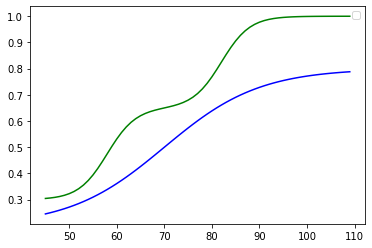

In [296]:
t = np.arange(45,110,1)

#t = np.array([50,50.5,51,52,53])
p1 = logistic(t, 0, 70, 0.2, 0.8, spaceshift=0)
p2 = sum_logistic(t, 0, 70, 0.3, 1, spaceshift=0) 
p3 = linear(t, 0, 70, 0.3, 0.9, spaceshift=0)
p1_source_neg = logistic(t, 0, 70, 0.2, 0.8, 8)
p2_source_neg = sum_logistic(t, 0, 70, 0.3, 1, -8) 
p3_source_neg = linear(t, 0, 70, 0.3, 0.9, -8)
p1_source_pos = logistic(t, 0, 70, 0.2, 0.8, -8)
p2_source_pos = sum_logistic(t, 0, 70, 0.3, 1, 8) 
p3_source_pos = linear(t, 0, 70, 0.3, 0.9, 8)

plt.plot(t,p1,c='b')
plt.plot(t,p2,c='g')
"""
plt.plot(t,p3,c='r')
plt.plot(t,p3_source_pos)
plt.plot(t,p3_source_neg)
plt.plot(t,p1_source_pos)
plt.plot(t,p1_source_neg)
"""
plt.legend()
plt.show()


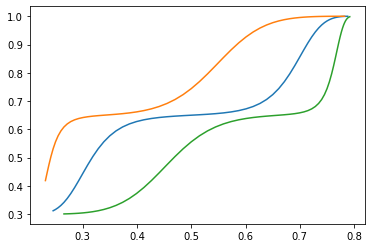

In [286]:
plt.plot(p1,p2)
plt.plot(p1_source_neg,p2_source_neg)
plt.plot(p1_source_pos,p2_source_pos)

In [320]:
# generation of the individual parameters

n_patients = 200

# individual_parameters
xi_mean = 0
sigma_xi = 0.5
tau_mean = 70
sigma_tau = 12
sources_std = 8

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,-0.467172,69.235519,5.448412
1,0.141372,71.472078,12.892324
2,-0.009877,79.211347,-6.932579
3,0.601632,72.958142,-6.276745
4,-0.084731,93.540652,-6.729603


In [321]:
feature_parameters.describe().drop('count')

,xi,tau,source
mean,0.064619,69.284587,0.201718
std,0.500238,12.337790,9.189670
min,-1.272378,32.086596,-27.167233
25%,-0.283963,60.709322,-6.078668
50%,0.077348,69.146426,0.333543
75%,0.400728,78.232877,6.452541
max,1.375289,99.229402,24.596020


In [322]:
# generate the associated trajectories 

visits_per_patients = 10
time_between_visits = 0.5
columns = ['feat1', 'feat2']

noise_std = 0.05

data = []
for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=15)
    #time_first_visit = 70
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    id_params = feature_parameters.loc[sub]
    feature_1 = logistic(np.array(timepoints), id_params[0], id_params[1], a=0.2, b=0.8, spaceshift=-id_params[2]/2) + np.random.normal(0, noise_std, visits_per_patients)
    feature_2 = sum_logistic(np.array(timepoints), id_params[0], id_params[1], a=0.3, b=1, spaceshift=id_params[2]/2)+ np.random.normal(0, noise_std, visits_per_patients)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [323]:
# Histogram of reparametrized ages

ages = []
for sub in data.index.unique():
    ip = feature_parameters.loc[sub]
    timepoints = data.loc[sub]['TIME']
    ages += list((np.exp(ip['xi'])*(timepoints - ip['tau']) + 70).values)
    

(array([  4.,   3.,   3.,   0.,   0.,   0.,   0.,   1.,   6.,  11.,  17.,
         17.,  15.,  37.,  21.,  34.,  43.,  64.,  94., 137., 176., 214.,
        188., 171., 170., 106.,  70.,  83.,  91.,  78.,  30.,  24.,  10.,
          9.,  11.,  25.,  15.,   6.,  10.,   6.]),
 array([-33.97648052, -29.40296804, -24.82945556, -20.25594308,
        -15.6824306 , -11.10891812,  -6.53540564,  -1.96189316,
          2.61161931,   7.18513179,  11.75864427,  16.33215675,
         20.90566923,  25.47918171,  30.05269419,  34.62620667,
         39.19971915,  43.77323162,  48.3467441 ,  52.92025658,
         57.49376906,  62.06728154,  66.64079402,  71.2143065 ,
         75.78781898,  80.36133146,  84.93484394,  89.50835641,
         94.08186889,  98.65538137, 103.22889385, 107.80240633,
        112.37591881, 116.94943129, 121.52294377, 126.09645625,
        130.66996872, 135.2434812 , 139.81699368, 144.39050616,
        148.96401864]),
 <BarContainer object of 40 artists>)

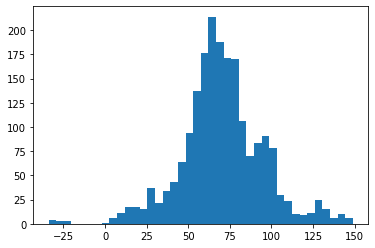

In [324]:
plt.hist(ages, bins=40)

In [314]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,500.000000,500.000000,500.000000
mean,74.515895,0.545826,0.705121
std,15.972290,0.196052,0.241094
min,32.356365,0.129203,0.186917
10%,50.586458,0.265332,0.339865
20%,61.688390,0.336217,0.492038
50%,76.007899,0.563336,0.692822
80%,88.174395,0.743895,0.966494
95%,99.957395,0.822124,1.040668
max,107.804217,0.923546,1.168449


In [325]:
data_path = 'simulated_study/simulated_data_2/'
data.to_csv(data_path + 'simulated_data_2.csv')
feature_parameters.to_csv(data_path + 'true_individual_parameters.csv')

## Save the data 

In [326]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [327]:
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

In [83]:
data.describe(percentiles=[.1,.2,.3,.5,.7,.8,.9, .95])

,TIME,feat1,feat2
count,800.000000,800.000000,800.000000
mean,71.252696,0.510620,0.655286
std,10.036833,0.189256,0.162464
min,45.421173,0.084783,0.136826
10%,58.891226,0.249743,0.439783
20%,62.573234,0.333949,0.551375
30%,64.859459,0.393284,0.593976
50%,71.445693,0.516825,0.654417
70%,76.979007,0.628455,0.721354
80%,79.929726,0.692023,0.785039


# Simualting other shapes

In [100]:
# logistic sampler from individidual parameters

def parabole(timepoints, acceleration, timeshift, b=1, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    res = []
    for time in timepoints:
        if time < timeshift+10:
            res.append(b + 0.015 * np.exp(acceleration) * (time-timeshift-10))
        else:
            res.append(b - 0.001 * np.exp(acceleration) * (time-timeshift-10))
    return res


No handles with labels found to put in legend.


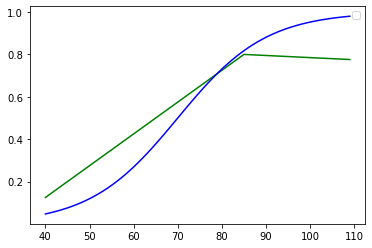

In [101]:
t = np.arange(40,110,1)

#t = np.array([50,50.5,51,52,53])
p1 = parabole(t, 0, 75, 0.8)
p2 = parabole(t, .5, 90, 0.6)
p2 = logistic(t, 0,70)

plt.plot(t,p1,c='g')
plt.plot(t,p2,c='b')
#plt.plot(t,p3,c='r')
plt.legend()
plt.show()


In [102]:
# generation of the individual parameters

n_patients = 100

# individual_parameters
xi_mean = 0
sigma_xi = 0.3
tau_mean = 70
sigma_tau = 15
sources_std = 5

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,-0.175778,57.756733,-1.355890
1,-0.238720,75.642463,6.598268
2,0.116582,85.564649,0.523944
3,0.052802,62.567019,-6.777056
4,-0.424887,81.243040,-4.828926


In [103]:
feature_parameters.describe()

,xi,tau,source
count,100.000000,100.000000,100.000000
mean,-0.048004,70.368737,0.924385
std,0.260868,15.061369,4.978492
min,-0.744761,30.993574,-10.900856
25%,-0.223839,60.936131,-1.629080
50%,-0.049820,69.566739,0.773087
75%,0.123217,79.854951,3.515674
max,0.694650,118.856039,19.841767


In [104]:
# generate the associated trajectories 

visits_per_patients = 5
time_between_visits = 0.5
columns = ['feat1', 'feat2']

data = []
for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=15)
    #time_first_visit = 50
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    id_params = feature_parameters.loc[sub]
    feature_1 = logistic(np.array(timepoints)-source/2, id_params[0], id_params[1], a=0.2, b=0.8)
    feature_2 = parabole(np.array(timepoints)+source/2, id_params[0], id_params[1], 0.9)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [105]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,500.000000,500.000000,500.000000
mean,74.232142,0.532547,0.709479
std,13.418058,0.184407,0.230161
min,44.208434,0.203052,-0.077608
10%,57.271929,0.233405,0.278952
20%,62.694745,0.360915,0.608271
50%,73.583601,0.538751,0.808576
80%,84.523642,0.722757,0.884959
95%,99.542561,0.792660,0.897120
max,107.328416,0.799820,0.899434


In [106]:
data.to_csv('simulated_data_with_sources_parabole.csv')

## Save the data 

In [107]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [108]:
np.savetxt('X.csv', X)
np.savetxt('Y.csv', Y, delimiter=',')
np.savetxt('group.csv', group)